In [18]:
import os, shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import trackpy
import yaml

params_dict = {
    'font.size' : 12,
    'axes.labelsize': 'medium',
    'xtick.top' : True,
    'ytick.right' : True,
    'axes.labelsize' : 16,
    'xtick.labelsize' : 14,
    'ytick.labelsize' : 14,
    'xtick.top' : True,
    'ytick.right' : True,
    'xtick.direction' : 'in',
    'ytick.direction' : 'in',
    'legend.frameon' : True,
    'svg.fonttype' : 'none',
    'pdf.fonttype' : 42,
    'savefig.transparent' : True
}
plt.rcParams.update(params_dict)
save_dir = os.path.join(os.getcwd(), 'figs_python')
if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
print(f' Figures will be saved in this folder:\n {save_dir}')

 Figures will be saved in this folder:
 \\cifs1.bpcentral.biophys.mpg.de\msdata\kimlab\SMC56LoopingProject\Manuscript\Nature\ResearchData\figs_python


In [19]:
def get_file_list(directory, extension=".tif", exclude_ext="_processed.tif", contains=None):
    file_list = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith(extension) and not file.endswith(exclude_ext):
                fpath = os.path.join(root, file)
                if contains is not None:
                    if contains in fpath:
                        file_list.append(fpath)
                else:
                    file_list.append(fpath)
    return file_list

In [20]:
# trans_dir = os.path.join(os.getcwd(), 'translocation_traces')
# if not os.path.isdir(trans_dir):
#     os.makedirs(trans_dir)

In [22]:
data_dir = r'./translocation_traces/' # translocation
filelist_msd = get_file_list(data_dir, extension=("_msd_rightpeak.csv"))
filecsv = filelist_msd[1]
df = pd.read_csv(filecsv)
length_list = []
dna_end_to_end_list = []
avg_msd = np.array([])
df_all = pd.DataFrame([])
particle_num = 1
for filpath in filelist_msd:
    # shutil.copy2(filpath, os.path.join(trans_dir, os.path.basename(filpath)))
    filepath_yaml = filpath[:-18]+'_params.yaml'
    if os.path.isfile(filepath_yaml):
        # shutil.copy2(filepath_yaml, os.path.join(trans_dir, os.path.basename(filepath_yaml)))
        with open(filepath_yaml) as f:
            params_yaml = yaml.safe_load(f)
            try:
                dna_ends = params_yaml['dna ends']
                dna_end_to_end_list.append(dna_ends)
            except:
                print(f'dna ends doesnot exist: {filepath_yaml}')

    df = pd.read_csv(filpath)
    if 'FrameNumber' in df.columns:
        df["particle"] = particle_num
        if df["x"].max() - df["x"].min() > 10:
            particle_num += 1
            df_all = pd.concat([df_all, df], ignore_index=True)
            length_list.append(len(df))
    else:
        print(f'{filpath} is not analyzed right!')

im = trackpy.imsd(df_all, 0.108, 5)  # microns per pixel = 100/285., frames per second = 24


In [23]:
len(filelist_msd)

32

Text(0.5, 0, 'DNA length')

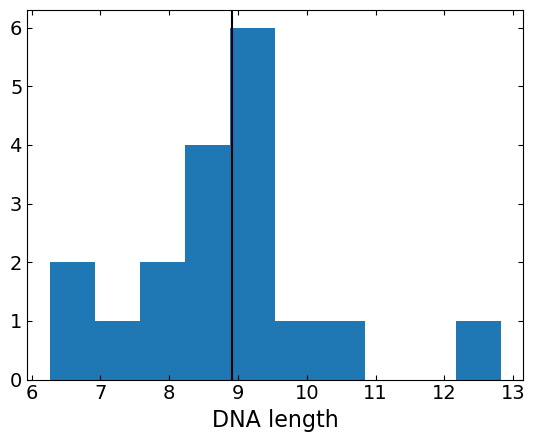

In [24]:
dna_end_to_end_list = np.array(dna_end_to_end_list)
dna_end_to_end_dist = 0.108 * (dna_end_to_end_list[:,1] - dna_end_to_end_list[:, 0])
dna_end_to_end_dist_mean = dna_end_to_end_dist.mean()
plt.hist(dna_end_to_end_dist);
plt.axvline(dna_end_to_end_dist_mean, color='k');
plt.xlabel('DNA length')

In [25]:
em = trackpy.emsd(df_all, 0.1, 5) # microns per pixel = 100/285., frames per second = 24

c:\Users\bipradha\Anaconda3\envs\leads-env\lib\site-packages\trackpy\motion.py:235: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = msds.mul(msds['N'], axis=0).mean(level=1)  # weighted average
c:\Users\bipradha\Anaconda3\envs\leads-env\lib\site-packages\trackpy\motion.py:236: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  results = results.div(msds['N'].mean(level=1), axis=0)  # weights normalized


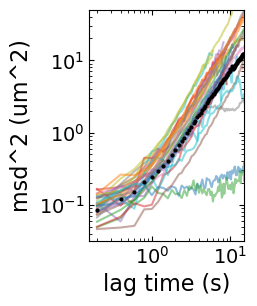

In [26]:

fig, ax = plt.subplots(figsize=(2,3))

for col in im.columns:
    _bool = im[col] > 0.01
    ax.plot(im.index[_bool], im[col][_bool], alpha=0.5)
    # ax.plot(np.log(im.index), np.log(im[col]), alpha=0.5)


ax.plot(em.index, em, 'ok', ms=2, label='ensemble msd')
# ax.plot(np.log(em.index), np.log(em), 'o', label='ensemble msd')

ax.set(ylabel='msd^2 (um^2)',
       xlabel='lag time (s)')
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim(None, 15)
ax.set_ylim(None, 50)
# ax.legend()
plt.savefig(os.path.join(save_dir, 'MSD_translocation.svg'))

Dfit:0.062um^2/s, Vfit:0.223um/s
Dfit:1.84+-0.06 kb^2/s, Vfit:1.21+-0.19, kb/s


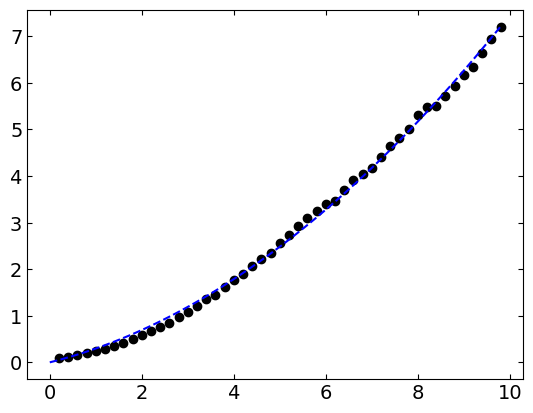

In [27]:
bool = np.logical_and(em.index>0, em.index<10)

plt.plot(em.index[bool], em[bool], 'ok', label='ensemble msd')

# https://tinevez.github.io/msdanalyzer/tutorial/MSDTuto_directed.html
def directed_motion(x, a, c):
    '''
    <r^2> = 4Dt + v^2*t^2
    a = 4D
    c = v^2
    '''
    return a*x + c*x**2

from scipy.optimize import curve_fit
popt, pcov = curve_fit(directed_motion, xdata=em.index[bool], ydata=em[bool])
a, c = popt
err = [pcov[0,0]**0.5, pcov[1,1]**0.5]
Dfit = round(a/4, 3)
Dfit_err = round(err[0]/4, 3)

Vfit = round(c**0.5, 3)
Vfit_err = round(err[1]**0.5, 3)
corr_factor_kb = 48.5/dna_end_to_end_dist_mean
Dfit_corr = round(Dfit*corr_factor_kb**2, 2)
Vfit_corr = round(Vfit*corr_factor_kb, 2)
Dfit_err_corr = round(Dfit_err*corr_factor_kb**2, 2)
Vfit_err_corr = round(Vfit_err*corr_factor_kb, 2)

print(f'Dfit:{Dfit}um^2/s, Vfit:{Vfit}um/s')
print(f'Dfit:{Dfit_corr}+-{Dfit_err_corr} kb^2/s, Vfit:{Vfit_corr}+-{Vfit_err_corr}, kb/s')

lagtime_sim = np.linspace(0, max(em.index[bool]), 100)
plt.plot(lagtime_sim, directed_motion(lagtime_sim, *popt), 'b--')
# plt.xscale('log')
# plt.yscale('log')



## intensity trce

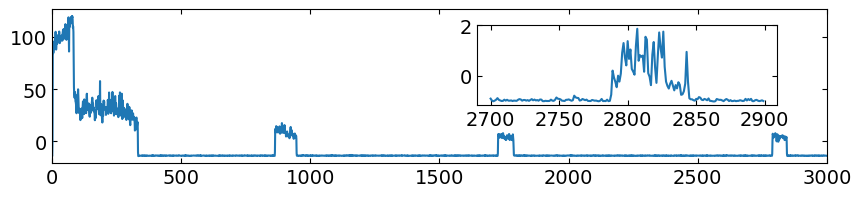

In [28]:
csv_file = r".\Selected_molecules\highsalt_wash\OctamerNse2SnapAl647\dna (19)\dna (19)_n2v_processed_inttrace.csv"
_df = pd.read_csv(csv_file, sep=',')
_df.head()
fig, ax1 = plt.subplots(figsize=(10,2))
_df = (_df["x0000"]-1500)/100
ax1.plot(_df)
ax1.set_xlim(0, 3000)

csv_file = r".\Selected_molecules\highsalt_wash\OctamerNse2SnapAl647\dna (19)\dna (19)_n2v_processed_inttrace_small_roi.csv"
_df = pd.read_csv(csv_file, sep=',')
_df = (_df["x0000"]-100)/100
left, bottom, width, height = [0.55, 0.4, 0.3, 0.4]
ax2 = fig.add_axes([left, bottom, width, height])
ax2.plot(_df[2700:2900])
plt.savefig(os.path.join(save_dir, 'timeTrace_highSaltWash.svg'))